# Coverage Results for Extremal Method

Results showcasing coverage of the extremal method.

Jimmy Butler
May 2025

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(mvtnorm)

source('/global/homes/j/jbbutler/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/confidenceRegions.R')

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'h

## Asymptotically Dependent Version

### Known Marginals

As our simulations have shown, it seems the projection method works best at survival function estimation when we have a distribution with a very heavy tailed copula, with heavy tailed marginal distributions. However, not every distribution will have very heavy tailed marginals, at least heavy enough for the regular variation asymptotics to be kicking in early. So, this means we need to do some kind of marginal transformation. First, we explore marginal transformation assuming we know the underlying marginal distributions (i.e. observing the performance of the method in an oracle case where we have perfect knowledge of the marginals).

### Unknown Marginals

The method we've been largely developing is one that works best with data whose underlying copula exhibits a high level of asymptotic depedence. This method involves converting the marginals of the distribution to a lomax distribution with shape parameter 1 (a distribution whose tails obey power law decay immediately) by estimating the marginal CDFs, and then using the blended survival function which uses regular variation to estimate extreme survival probabilities in M+P (2015).

#### Data Distribution: Bivariate t with $\nu = 1$

In [5]:
path <- '/pscratch/sd/j/jbbutler/extreme_tubes/marginals_unknown/copula_tdf1_marginals_tdf1/p5_div_n/'
fnames <- list.files(path)
n_sims <- 500

full_res <- vector(mode='list', length=length(fnames))

for (i in 1:length(fnames)) {
    fname <- fnames[i]
    n_res <- readRDS(paste0(path, fname))
    n_res_lst <- vector(mode='list', length=n_sims)
    for (j in 1:n_sims) {
        sim_res <- n_res[[j]]
        n <- nrow(sim_res$dat)
        p <- sim_res$p
        alphas <- sim_res$alphas
        alphas_lst <- vector(mode='list', length=length(alphas))
        for (k in 1:length(alphas)) {
            alpha <- alphas[k]
            c_estimate <- sim_res$c_estimates[[as.character(alpha)]]
            is_covered <- sim_res$is_covereds[[as.character(alpha)]]
            alphas_lst[[k]] <- c(n, p, alpha, c_estimate, is_covered)
        }   
        n_res_lst[[j]] <- do.call(rbind, alphas_lst)
    }
    full_res[[i]] <- do.call(rbind, n_res_lst)
}
full_res <- data.frame(do.call(rbind, full_res))
colnames(full_res) <- c('n', 'p', 'alpha', 'c_alpha', 'is_covered')


ERROR: Error in alphas_lst[[k]] <- c(n, p, alpha, c_estimate, is_covered): attempt to select less than one element in integerOneIndex


In [2]:
full_res %>% group_by(n, alpha) %>% summarize(covrate=mean(is_covered)) %>% arrange(alpha)

ERROR: Error in full_res %>% group_by(n, alpha) %>% summarize(covrate = mean(is_covered)) %>% : could not find function "%>%"


What do the confidence tubes even look like? Let's draw for an example region.

In [81]:
n <- 10000
alphas <- c(0.05, 0.1, 0.01)
gamma <- 1/2
xi <- 1
p <- 5/n
B <- 500

numCoords <- 200
ub <- qt(1-(5/n), df=1) + 100
lvlset_ubs <- c(ub, ub)
lvlset_lbs <- c(0, 0)

rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    return(dat)
}

In [96]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')
isoline <- drawBivtIsoline(numCoords=numCoords, gridUbs=lvlset_ubs, gridLbs=lvlset_lbs, prob=p, df=1)

In [83]:
dat <- rdist(n)

transform <- function(pts, dat) {
    transformed_pts <- 1/(1-est_cdf(pts, dat, gamma)) - 1
    return(transformed_pts)
}

transformed_dat_X1 <- transform(dat[,1], dat[,1])
transformed_dat_X2 <- transform(dat[,2], dat[,2])
transformed_dat <- data.frame(X1=transformed_dat_X1, X2=transformed_dat_X2)
    
regions <- drawExtremeRegion(transformed_dat, alphas, p, B, gamma, xi)

In [138]:
transformed_isoline <- data.frame(X1=transform(isoline[,1], dat[,1]), X2=transform(isoline[,2], dat[,2]))
est_survfunc <- apply(transformed_isoline, 1, blendedSurvivalFunc, dat=transformed_dat, gamma=gamma, xi=xi)
is_covereds <- list()
cs <- regions$c_estimates

for (i in 1:length(alphas)) {
    alpha <- alphas[i]
    c <- cs[[as.character(alpha)]]
    is_covereds[as.character(alpha)] <- all((est_survfunc <= p + c) & (est_survfunc >= p - c))
}
regions$is_covereds <- is_covereds

In [139]:
lower <- drawExtremeIsoline(transformed_dat, 5/n + regions$c_estimates[[2]], n_coords, gridLbs, gamma, xi)
upper <- drawExtremeIsoline(transformed_dat, 5/n - regions$c_estimates[[2]], n_coords, gridLbs, gamma, xi)

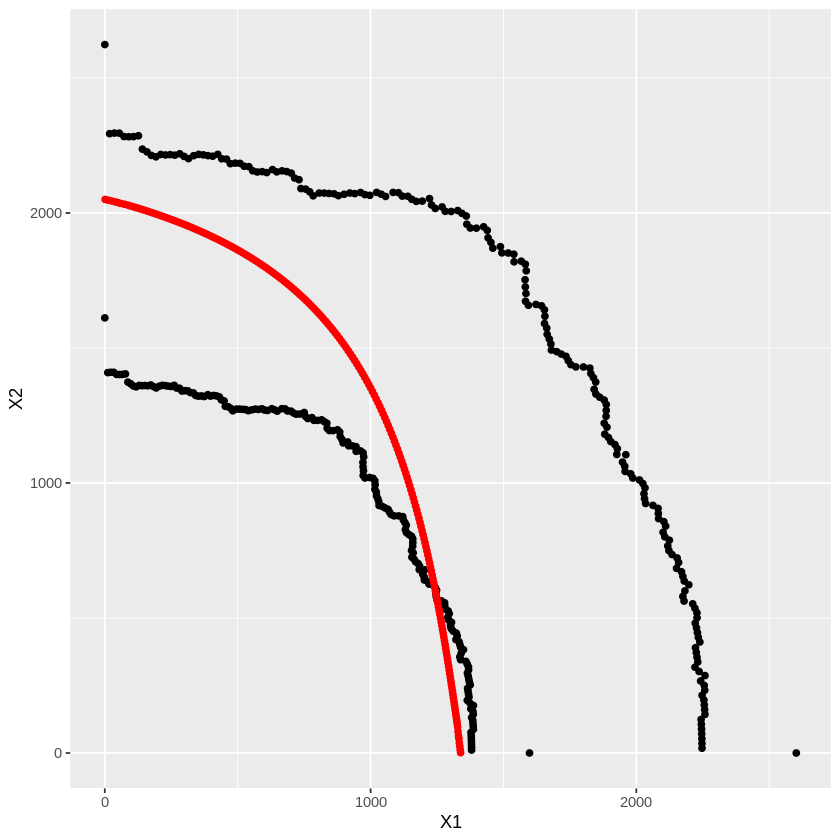

In [140]:
ggplot() + geom_point(data=lower, aes(x=X1, y=X2)) + geom_point(data=upper, aes(x=X1, y=X2)) + geom_point(data=transformed_isoline, aes(x=X1, y=X2), color='red')



In [132]:
pts <- seq(0, 100, length.out=100)
cdf_1 <- est_cdf(pts, dat[,1], 0.5)
cdf_2 <- est_cdf(pts, dat[,2], 0.5)

df <- data.frame(pts=pts, cdf_1=cdf_1, cdf_2=cdf_2)

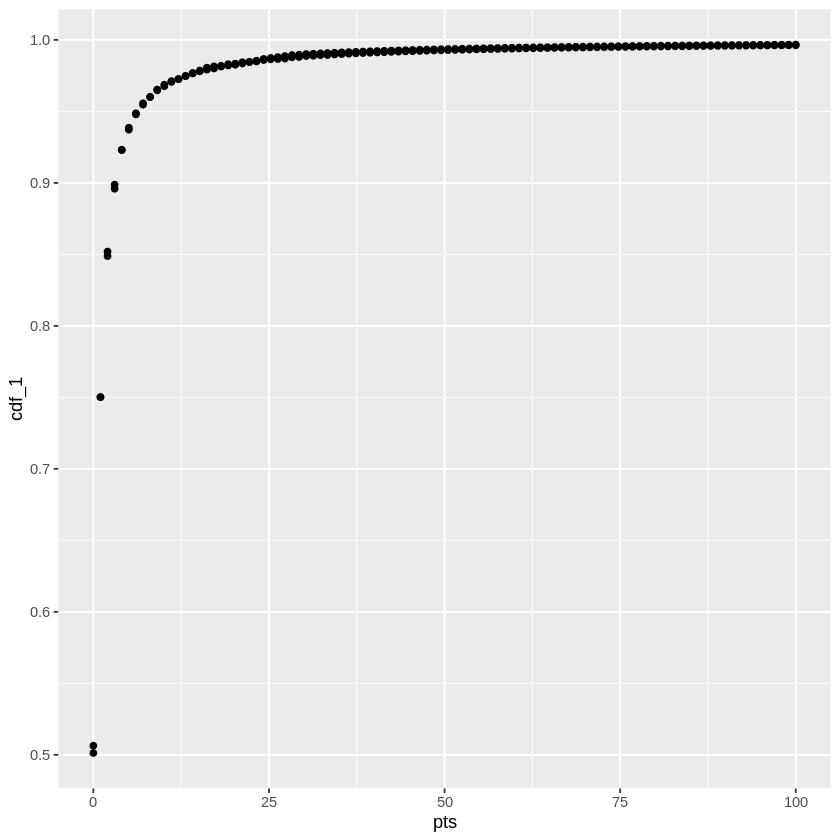

In [137]:
ggplot() + geom_point(data=df, aes(x=pts, y=cdf_1)) + geom_point(data=df, aes(x=pts, y=cdf_2))

### Known Marginals

Let's just do these simulations assuming we know what the marginal distributions are. What we find is that the coverage looks great for this case. Not sure why the unknown marginals case looks so bad, and why it gets so much worse as sample size gets larger (shouldn't the marginal estimation be getting much better as sample size get's larger? this is a pretty well-known and solvable problem I feel)

In [9]:
path <- '/pscratch/sd/j/jbbutler/extreme_tubes/marginals_known/copula_tdf1_marginals_tdf1/p5_div_n/'
fnames <- list.files(path)
n_sims <- 500

full_res <- vector(mode='list', length=length(fnames))

for (i in 1:length(fnames)) {
    fname <- fnames[i]
    n_res <- readRDS(paste0(path, fname))
    n_res_lst <- vector(mode='list', length=n_sims)
    for (j in 1:n_sims) {
        sim_res <- n_res[[j]]
        n <- nrow(sim_res$dat)
        p <- sim_res$p
        alphas <- sim_res$alphas
        alphas_lst <- vector(mode='list', length=length(alphas))
        for (k in 1:length(alphas)) {
            alpha <- alphas[k]
            c_estimate <- sim_res$c_estimates[[as.character(alpha)]]
            is_covered <- sim_res$is_covereds[[as.character(alpha)]]
            alphas_lst[[k]] <- c(n, p, alpha, c_estimate, is_covered)
        }   
        n_res_lst[[j]] <- do.call(rbind, alphas_lst)
    }
    full_res[[i]] <- do.call(rbind, n_res_lst)
}
full_res <- data.frame(do.call(rbind, full_res))
colnames(full_res) <- c('n', 'p', 'alpha', 'c_alpha', 'is_covered')


In [10]:
full_res %>% group_by(n, alpha) %>% summarize(covrate=mean(is_covered)) %>% arrange(alpha)

`summarise()` has grouped output by 'n'. You can override using the `.groups`
argument.


n,alpha,covrate
<dbl>,<dbl>,<dbl>
1000,0.01,0.996
5000,0.01,0.998
10000,0.01,0.998
50000,0.01,0.996
1000,0.05,0.988
5000,0.05,0.988
10000,0.05,0.986
50000,0.05,0.986
1000,0.10,0.960


### Diagnosing Undercoverage

In [7]:
ex <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/copula_tdf1_marginals_tdf1/p5_div_n/n10000_tubes_10.RData')

In [14]:
ex[['regions_ecdf']]

X1,X2
<dbl>,<dbl>
0.35722041,0.25125125
1.26603218,3.02252615
6.65696784,8.95024876
0.69118891,0.61786119
0.06462259,0.09098844
0.78539547,0.66251039
0.14995400,0.98767641
0.12650670,0.25109471
0.24038700,0.13340134


In [15]:
ex[['regions_known']]

X1,X2
<dbl>,<dbl>
0.35969660,0.25316386
1.27327132,2.92247527
6.29182636,8.54424599
0.67616531,0.60457185
0.06688904,0.09274677
0.76890381,0.65018365
0.15362851,0.95664539
0.13092626,0.25314814
0.24611122,0.13548926


In [8]:
names(ex)

[1] "regions_ecdf"  "regions_known" "orig_dat"

In [13]:
ex1 <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/copula_tdf1_marginals_tdf1/p5_div_n/n10000_tubes_1.RData')
ex2 <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/copula_tdf1_marginals_tdf1/p5_div_n/n10000_tubes_2.RData')


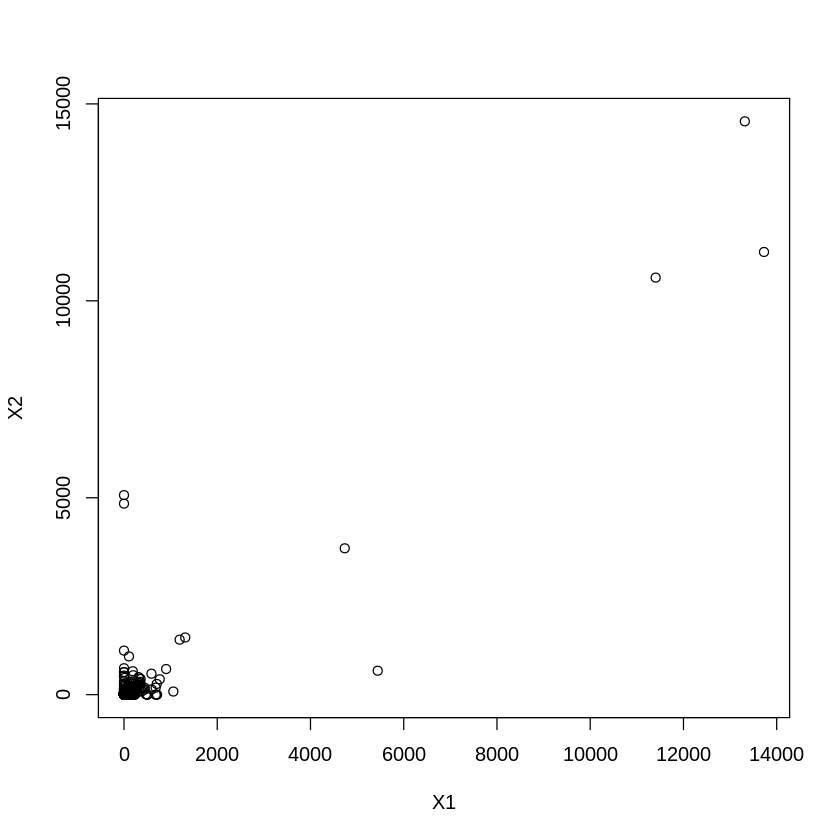

In [14]:
plot(ex1[['regions_ecdf']][['dat']])

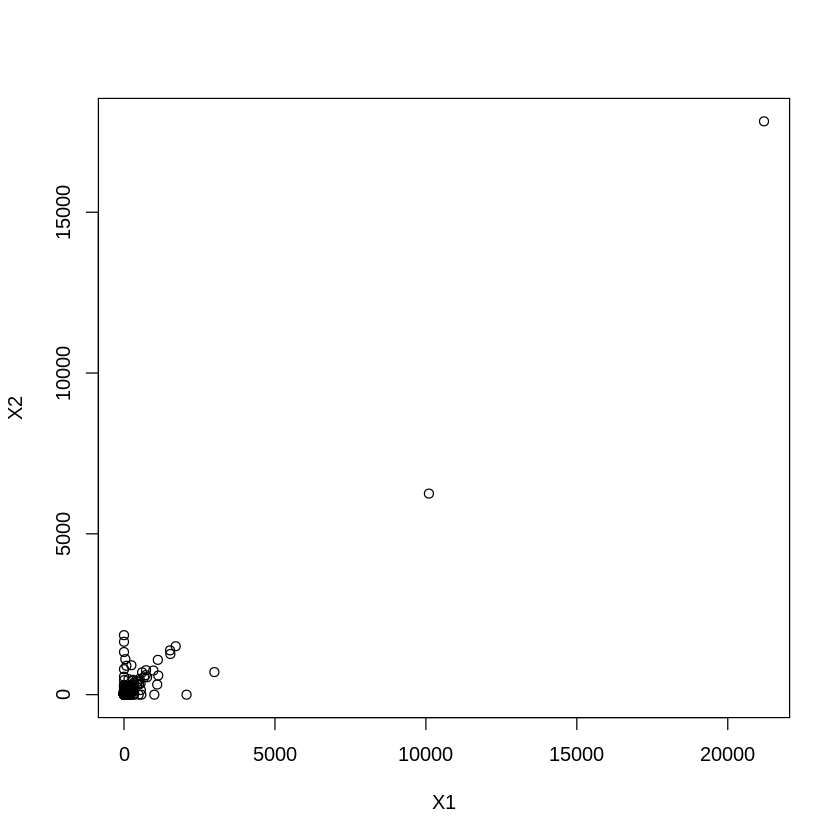

In [15]:
plot(ex2[['regions_ecdf']][['dat']])

### Wrong Isoline 1

In [2]:
res <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/wrong_isoline/copula_tdf1_marginals_tdf1/p5_div_n/n10000_tubes.RData')

In [7]:
n_sims <- 500

full_res <- vector(mode='list', length=n_sims)

for (j in 1:n_sims) {
    sim_res <- res[[j]]
    n <- nrow(sim_res$dat)
    p <- sim_res$p
    alphas <- sim_res$alphas
    alphas_lst <- vector(mode='list', length=length(alphas))
    for (k in 1:length(alphas)) {
        alpha <- alphas[k]
        c_estimate <- sim_res$c_estimates[[as.character(alpha)]]
        is_covered_true <- sim_res$is_covereds_true[[as.character(alpha)]]
        is_covered_wrong <- sim_res$is_covereds_wrong[[as.character(alpha)]]
        alphas_lst[[k]] <- c(n, p, alpha, c_estimate, is_covered_true, is_covered_wrong)
    }   
    full_res[[j]] <- do.call(rbind, alphas_lst)
}

full_res <- data.frame(do.call(rbind, full_res))
colnames(full_res) <- c('n', 'p', 'alpha', 'c_alpha', 'is_covered_true', 'is_covered_wrong')

In [14]:
full_res %>% select(is_covered_true, is_covered_wrong, alpha) %>% group_by(alpha) %>% summarize(covrate_true=mean(is_covered_true), covrate_wrong=mean(is_covered_wrong))

alpha,covrate_true,covrate_wrong
<dbl>,<dbl>,<dbl>
0.01,0.590,1
0.05,0.408,1
0.10,0.310,1


### Wrong Isoline 2

In [9]:
sim_dir <- '/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/wrong_isoline2/copula_tdf1_marginals_tdf1/p5_div_n/'
datasets <- list.files(sim_dir)

In [21]:
sim_res <- vector(mode='list', length=length(datasets))
for (i in 1:length(datasets)) {
    dataset_name <- datasets[i]
    simulations <- list.files(paste0(sim_dir, dataset_name))
    dataset_res <- vector(mode='list', length=length(simulations))

    for (j in 1:length(simulations)) {
        sim_name <- simulations[j]
        tubes <- readRDS(paste0(sim_dir, dataset_name, '/', sim_name))

        alphas <- tubes$alphas
        alphas_lst <- vector(mode='list', length=length(alphas))
        for (k in 1:length(alphas)) {
            alpha <- alphas[k]
            c_estimate <- tubes$c_estimates[[as.character(alpha)]]
            is_covered <- tubes$is_covereds[[as.character(alpha)]]
            alphas_lst[[k]] <- c(alpha, c_estimate, is_covered)
        }   
        dataset_res[[j]] <- do.call(rbind, alphas_lst)
    }
    sim_res[[i]] <- do.call(rbind, dataset_res)
}

In [30]:
res <- data.frame(sim_res[[1]])
colnames(res) <- c('alpha', 'c', 'is_covered')
res %>% group_by(alpha) %>% summarize(covrate=mean(is_covered))

alpha,covrate
<dbl>,<dbl>
0.01,0.566
0.05,0.390
0.10,0.310


In [31]:
res <- data.frame(sim_res[[2]])
colnames(res) <- c('alpha', 'c', 'is_covered')
res %>% group_by(alpha) %>% summarize(covrate=mean(is_covered))

alpha,covrate
<dbl>,<dbl>
0.01,0.612
0.05,0.426
0.10,0.324


In [32]:
res <- data.frame(sim_res[[3]])
colnames(res) <- c('alpha', 'c', 'is_covered')
res %>% group_by(alpha) %>% summarize(covrate=mean(is_covered))

alpha,covrate
<dbl>,<dbl>
0.01,0.556
0.05,0.364
0.10,0.266


In [33]:
res <- data.frame(sim_res[[4]])
colnames(res) <- c('alpha', 'c', 'is_covered')
res %>% group_by(alpha) %>% summarize(covrate=mean(is_covered))

alpha,covrate
<dbl>,<dbl>
0.01,0.596
0.05,0.414
0.10,0.312


In [34]:
res <- data.frame(sim_res[[5]])
colnames(res) <- c('alpha', 'c', 'is_covered')
res %>% group_by(alpha) %>% summarize(covrate=mean(is_covered))

alpha,covrate
<dbl>,<dbl>
0.01,0.572
0.05,0.396
0.10,0.306
